In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe

import utils
import word2vec_utils

tf.enable_eager_execution()

In [2]:
# Model hyperparameters
VOCAB_SIZE = 50000
BATCH_SIZE = 128
EMBED_SIZE = 128            # dimension of the word embedding vectors
SKIP_WINDOW = 1             # the context window
NUM_SAMPLED = 64            # number of negative examples to sample
LEARNING_RATE = 1.0
NUM_TRAIN_STEPS = 100000
VISUAL_FLD = 'visualization'
SKIP_STEP = 5000

# Parameters for downloading data
DOWNLOAD_URL = 'http://mattmahoney.net/dc/text8.zip'
EXPECTED_BYTES = 31344016

In [4]:
class Word2Vec(object):
  def __init__(self, vocab_size, embed_size, num_sampled=NUM_SAMPLED):
    self.vocab_size = vocab_size
    self.num_sampled = num_sampled
    self.embed_size = embed_size
    # Create the variables: an embedding matrix, nce_weight, and nce_bias
    self.embed_matrix = tfe.Variable(tf.random_uniform([self.vocab_size, self.embed_size]))
    self.nce_weight = tfe.Variable(tf.truncated_normal([self.vocab_size, self.embed_size], \
                                                       stddev=1.0 / (self.embed_size ** 0.5)))
    self.nce_bias = tfe.Variable(tf.zeros([VOCAB_SIZE]))

  def compute_loss(self, center_words, target_words):
    """Computes the forward pass of word2vec with the NCE loss.""" 
    # Look up the embeddings for the center words
    self.embed = tf.nn.embedding_lookup(self.embed_matrix, center_words, name='embedding')

    # Compute the loss, using tf.reduce_mean and tf.nn.nce_loss
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                                biases=self.nce_bias, 
                                                labels=target_words, 
                                                inputs=self.embed, 
                                                num_sampled=self.num_sampled, 
                                                num_classes=self.vocab_size), name='loss')
    return loss

def gen():
  yield from word2vec_utils.batch_gen(DOWNLOAD_URL, EXPECTED_BYTES,
                                      VOCAB_SIZE, BATCH_SIZE, SKIP_WINDOW,
                                      VISUAL_FLD)


In [27]:
model.embed_matrix.shape, total_loss, batch_loss.numpy()

(TensorShape([Dimension(50000), Dimension(128)]), 0.0, 4.9564548)

In [26]:
batch_loss

<tf.Tensor: id=39544390, shape=(), dtype=float32, numpy=4.9564548>

In [25]:
model.embed_matrix

<tf.Variable 'Variable:0' shape=(50000, 128) dtype=float32, numpy=
array([[ 0.42704237,  0.41064057,  0.571266  , ...,  0.10017863,
         0.33000904,  0.7825291 ],
       [ 0.406902  ,  0.5639415 ,  0.67464346, ..., -0.27519652,
         0.32224768,  0.41596514],
       [ 0.6889662 ,  0.29735434,  0.8806458 , ..., -0.03277445,
        -0.71932846,  0.7661115 ],
       ...,
       [ 0.18792987,  0.39667308,  0.3776164 , ...,  0.10308731,
         0.7350985 ,  0.12254226],
       [ 0.03663949,  0.11622635,  0.2128198 , ...,  0.23194492,
         0.15022887,  0.3141573 ],
       [ 0.29074836,  0.6719403 ,  0.5825194 , ...,  0.45320237,
         0.17456162,  0.19768763]], dtype=float32)>

In [22]:
# main
dataset = tf.data.Dataset.from_generator(gen, (tf.int32, tf.int32),
                          (tf.TensorShape([BATCH_SIZE]),
                          tf.TensorShape([BATCH_SIZE, 1])))
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
# Create the model
model = Word2Vec(VOCAB_SIZE, EMBED_SIZE, NUM_SAMPLED)

# Create the gradients function, using `tfe.implicit_value_and_gradients`

grad_fn = tfe.implicit_value_and_gradients(model.compute_loss)

total_loss = 0.0  # for average loss in the last SKIP_STEP steps
num_train_steps = 0
while num_train_steps < NUM_TRAIN_STEPS:
    for center_words, target_words in tfe.Iterator(dataset):
        if num_train_steps >= NUM_TRAIN_STEPS:
            break

        # Compute the loss and gradients, and take an optimization step.
        batch_loss, grads = grad_fn(center_words, target_words)
        optimizer.apply_gradients(grads)
        total_loss += batch_loss

        if (num_train_steps + 1) % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(num_train_steps, total_loss / SKIP_STEP))
            total_loss = 0.0
        num_train_steps += 1

Average loss at step 4999:  65.3
Average loss at step 9999:  18.3
Average loss at step 14999:   9.6
Average loss at step 19999:   6.8
Average loss at step 24999:   5.7
Average loss at step 29999:   5.2
Average loss at step 34999:   5.0
Average loss at step 39999:   4.8
Average loss at step 44999:   4.8
Average loss at step 49999:   4.8
Average loss at step 54999:   4.7
Average loss at step 59999:   4.7
Average loss at step 64999:   4.6
Average loss at step 69999:   4.7
Average loss at step 74999:   4.6
Average loss at step 79999:   4.7
Average loss at step 84999:   4.7
Average loss at step 89999:   4.7
Average loss at step 94999:   4.6
Average loss at step 99999:   4.6


In [ ]:
!!!!!!!!!!!!!!! Attention !!!!!!!!!!!!!!!!!!!!!!!!!!!
# RMK: similarities between words are evaluated with 
# the cosine similarity between their embeddings (low-dim projections)
# similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
#     or      = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)

In [28]:
embeddings = model.embed_matrix
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
final_embeddings = normalized_embeddings.numpy()

In [29]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [30]:
plot_only = 200
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [61]:
# For labels:
fwords = open(os.path.join("visualization", 'vocab.tsv'), 'r')
words = [word.rstrip() for word in fwords]
labels = [word.rstrip() for word in fwords.readlines(plot_only)]
# labels = [vocabulary[i] for i in range(plot_only)]
fwords.close()

In [46]:
labels[:10]

['UNK', 'the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine']

In [86]:
from matplotlib import pyplot as plt
def plot_with_labels(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(10,10))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  plt.show()

In [50]:
low_dim_embs.shape

(200, 2)

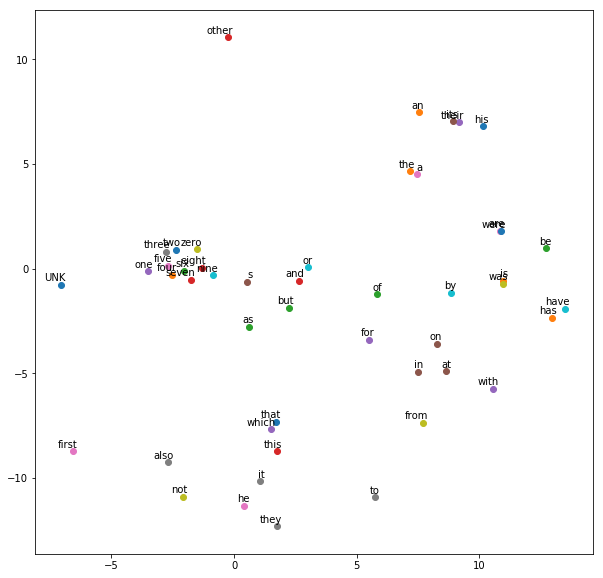

In [58]:
plot_with_labels(low_dim_embs, labels)
# you can see numbers next to each other, prepositions, pronouns ...

In [112]:
print([i for i,j in enumerate(words) if j=='tokyo'])

[4911]


In [114]:
cities = ["rome","madrid","paris","marrakech","finland","uae","usa","japan","china"]
countries = ["italy","spain","france","morocco","helsinki","dubai","washington","tokyo","beijing"]
places = cities + countries
places_id = [i for i,j in enumerate(words) if j in places]

In [95]:
print([i for i,j in enumerate(words) if j in cities])
print([i for i,j in enumerate(words) if j in countries])
places_id = [i for i,j in enumerate(words) if j in places]

[938, 1055, 4729, 21199]
[303, 804, 843, 3385]


In [115]:
places_embs = tsne.fit_transform(final_embeddings[places_id,:])

In [117]:
from matplotlib import pyplot as plt
def plot_to_places(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(10,10))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  plt.show()

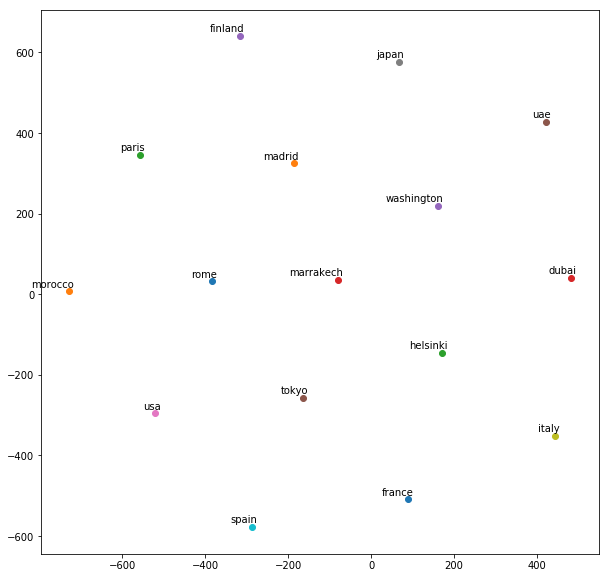

In [116]:
plot_to_places(places_embs, places)